In [1]:
import numpy as np
import pandas as pd
import optuna
import pickle
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor, plot_importance
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
train_df = pd.read_csv("../output/0_data_cleaning/lightgbm/lag1_diff1/train_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})
test_df = pd.read_csv("../output/0_data_cleaning/lightgbm/lag1_diff1/test_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})

In [3]:
train_df

,year,country,population_lag_1,gdp_lag_1,temperature_change_from_co2_lag_1,cement_co2_lag_1,coal_co2_lag_1,flaring_co2_lag_1,gas_co2_lag_1,land_use_change_co2_lag_1,oil_co2_lag_1,co2
0,1929,Argentina,0.006899,0.171127,0.507331,0.015554,0.048410,0.000000,0.003933,0.311606,0.022520,0.292283
1,1930,Argentina,0.007131,0.174392,0.493851,0.022711,0.047334,0.000000,0.005904,0.306015,0.022659,0.236081
2,1931,Argentina,0.007348,0.162400,0.481904,0.024072,0.045068,0.000000,0.005711,0.252516,0.021200,0.199768
3,1932,Argentina,0.007548,0.146788,0.471364,0.033014,0.037719,0.000000,0.006939,0.217711,0.026236,0.179355
4,1933,Argentina,0.007730,0.138581,0.462130,0.030168,0.033701,0.000000,0.009276,0.198031,0.029199,0.165318
...,...,...,...,...,...,...,...,...,...,...,...,...
3139,2003,Vietnam,0.059915,0.070411,0.070078,0.153245,0.022190,0.001236,0.007499,0.089355,0.022043,0.068187
3140,2004,Vietnam,0.060551,0.075243,0.069361,0.171695,0.025545,0.001445,0.009425,0.092293,0.022477,0.070668
3141,2005,Vietnam,0.061188,0.080752,0.068657,0.186919,0.027515,0.001409,0.015698,0.093135,0.025559,0.064508
3142,2006,Vietnam,0.061822,0.086439,0.067971,0.215267,0.030893,0.001344,0.016666,0.086350,0.025280,0.061692


In [4]:
# Load the fitted DataScaler object
with open('../output/0_data_cleaning/lightgbm/lag1_diff1/data_preprocessor_lightgbm.pkl', 'rb') as f:
    data_preprocessor_lightgbm = pickle.load(f)

In [5]:
# Count rows for each country in train and test datasets
train_country_counts = train_df['country'].value_counts().reset_index()
train_country_counts.columns = ['country', 'train_count']

test_country_counts = test_df['country'].value_counts().reset_index()
test_country_counts.columns = ['country', 'test_count']

# Merge the counts into a single DataFrame
country_counts_df = pd.merge(
    train_country_counts,
    test_country_counts,
    on='country',
    how='outer'  # Keeps all countries, even if they are only in train or test
).fillna(0)  # Fill missing counts with 0 if a country is missing in one dataset

# Ensure counts are integers
country_counts_df['train_count'] = country_counts_df['train_count'].astype(int)
country_counts_df['test_count'] = country_counts_df['test_count'].astype(int)

# Display the result
country_counts_df.sort_values(by=['train_count'], ascending=False)

,country,train_count,test_count
41,United States,136,35
23,Netherlands,136,35
16,Indonesia,106,27
21,Malaysia,97,25
43,Venezuela,94,24
35,Sweden,91,23
33,South Korea,88,23
8,Colombia,80,21
27,Philippines,75,19
1,Australia,75,19


In [6]:
def log_mape(y_true, y_pred):
    return np.mean(np.abs((np.log1p(y_true) - np.log1p(y_pred)) / np.log1p(y_true)))

In [7]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 8, 30), #4/5-30 moje: 1, 30
        #'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 0.001, 10),
        'max_depth': trial.suggest_int('max_depth', 1, 5), # 1-5 moje: 3, 12
        'num_threads': trial.suggest_int('num_threads', 1, 5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100), # 10-100 moje: 100, 1000
        #deal with overfitting
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 6.0, 10.0),

        'verbosity': -1,

        'objective':'regression_l1',
        # 'metric':'mae',
        # 'is_unbalance':True,
    }

    # Initialize the model
    model_optuna = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model_optuna = MLForecast(
        models=[model_optuna],
        freq=1,
        date_features=None,
        num_threads=2
    )

    # Perform cross-validation manually with dynamic horizons
    all_cv_predictions = []

    for country, country_data in train_df.groupby('country'):
        # Calculate the horizon dynamically
        horizon = max(1, int(0.15 * len(country_data)))

        # Perform cross-validation for this country
        cv_predictions = forecast_model_optuna.cross_validation(
            df=country_data,
            h=horizon,
            n_windows=2,
            step_size=horizon//2,
            id_col='country',
            time_col='year',
            target_col='co2',
            static_features=[]
        )

        # Add the country information to the predictions
        cv_predictions['country'] = country
        all_cv_predictions.append(cv_predictions)

    # Concatenate all predictions into a single DataFrame
    cv_predictions = pd.concat(all_cv_predictions).reset_index(drop=True)

    # Rename 'LGBMRegressor' to 'co2_predicted'
    cv_predictions = cv_predictions.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
    cv_predictions = cv_predictions.dropna(subset=['co2_actual', 'co2_predicted'])

    # Calculate MAPE
    # mape = mean_absolute_percentage_error(cv_predictions['co2_actual'], cv_predictions['co2_predicted'])

    # return mape
    # Calculate log-MAPE
    log_mape_value = log_mape(cv_predictions['co2_actual'], cv_predictions['co2_predicted'])

    return log_mape_value 

In [8]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-11-21 22:01:09,290] A new study created in memory with name: no-name-e6c2a45f-77a8-4317-87a0-f61ef4c06bae
[I 2024-11-21 22:01:11,580] Trial 0 finished with value: 0.14358302867322598 and parameters: {'learning_rate': 0.08851782585381036, 'num_leaves': 43, 'min_data_in_leaf': 14, 'max_depth': 4, 'num_threads': 3, 'n_estimators': 99, 'bagging_fraction': 0.9016913723278043, 'feature_fraction': 0.814984768684116, 'lambda_l1': 2.234259007831305, 'lambda_l2': 8.594058231373058}. Best is trial 0 with value: 0.14358302867322598.
[I 2024-11-21 22:01:12,883] Trial 1 finished with value: 0.24871320653272405 and parameters: {'learning_rate': 0.09012522309898417, 'num_leaves': 27, 'min_data_in_leaf': 26, 'max_depth': 3, 'num_threads': 1, 'n_estimators': 20, 'bagging_fraction': 0.868888099654626, 'feature_fraction': 0.8161269782424273, 'lambda_l1': 2.633649167877508, 'lambda_l2': 7.226143919730687}. Best is trial 0 with value: 0.14358302867322598.
[I 2024-11-21 22:01:14,597] Trial 2 finished

Best Hyperparameters: {'learning_rate': 0.08851782585381036, 'num_leaves': 43, 'min_data_in_leaf': 14, 'max_depth': 4, 'num_threads': 3, 'n_estimators': 99, 'bagging_fraction': 0.9016913723278043, 'feature_fraction': 0.814984768684116, 'lambda_l1': 2.234259007831305, 'lambda_l2': 8.594058231373058}


In [9]:
best_params

{'learning_rate': 0.08851782585381036,
 'num_leaves': 43,
 'min_data_in_leaf': 14,
 'max_depth': 4,
 'num_threads': 3,
 'n_estimators': 99,
 'bagging_fraction': 0.9016913723278043,
 'feature_fraction': 0.814984768684116,
 'lambda_l1': 2.234259007831305,
 'lambda_l2': 8.594058231373058}

In [23]:
# Initialize the model with best hyperparameters
best_model = LGBMRegressor(
    #**best_params,
    learning_rate= 0.08851782585381036, 
    num_leaves= 43, 
    min_data_in_leaf= 14,
    max_depth= 4, 
    num_threads= 3, 
    n_estimators= 99, 
    bagging_fraction= 0.9016913723278043, 
    feature_fraction= 0.814984768684116, 
    lambda_l1= 2.234259007831305, 
    lambda_l2= 8.594058231373058,
    verbosity=-1,

    objective= 'regression_l1',
    # metric= 'mae',
    # is_unbalance= False,
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    #lags=[1],
    date_features=None,
    num_threads=2
)

train_transformed = forecast_model.preprocess(
    df=train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[]
)

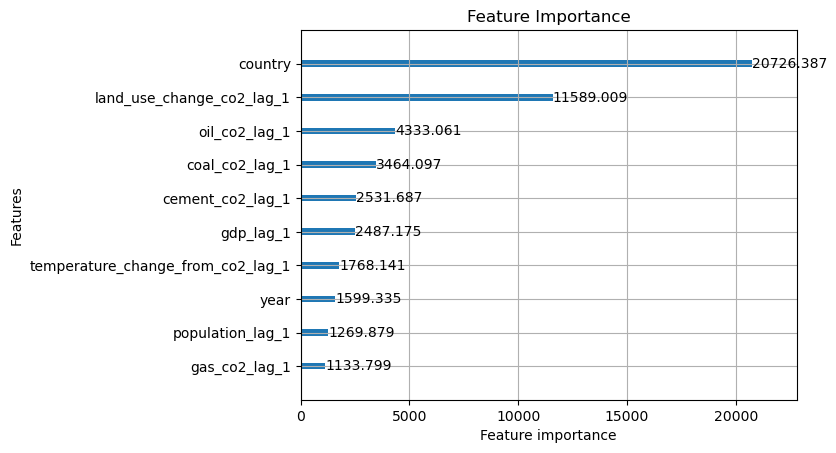

In [24]:
#Check feature importance
# Separate features and target
X_train = train_transformed.drop(columns=['co2'])
y_train = train_transformed['co2']

# Convert 'country' to a categorical feature
X_train['country'] = X_train['country'].astype('category')

# Fit the LightGBM model
best_model.fit(X_train, y_train, categorical_feature=['country'])

# Plot feature importance
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [25]:
# Fit the model on the entire training data
forecast_model.fit(
    train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[],
    fitted=True
)

MLForecast(models=[LGBMRegressor], freq=1, lag_features=[], date_features=[], num_threads=2)

In [26]:
#TRAIN DATA
fitted_values = forecast_model.forecast_fitted_values()
results_train = fitted_values.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

#predicted inverse transform
results_train_inverse = results_train.copy()

output_train_predicted = results_train['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_train_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_train_predicted, results_train.shape[0], train_df.shape[1]-2)
last_column_train_predicted = inverted_data_train_predicted[:, -1]
results_train_inverse['co2_predicted'] = last_column_train_predicted

output_train_actual = results_train['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_train_actual = data_preprocessor_lightgbm.inverse_transform_data(output_train_actual, results_train.shape[0], train_df.shape[1]-2)
last_column_train_actual = inverted_data_train_actual[:, -1]
results_train_inverse['co2_actual'] = last_column_train_actual

results_train_inverse

,country,year,co2_actual,co2_predicted
0,Argentina,1929,0.000021,0.000021
1,Argentina,1930,0.000017,0.000019
2,Argentina,1931,0.000014,0.000018
3,Argentina,1932,0.000012,0.000013
4,Argentina,1933,0.000011,0.000012
...,...,...,...,...
3139,Vietnam,2003,0.000003,0.000002
3140,Vietnam,2004,0.000003,0.000002
3141,Vietnam,2005,0.000002,0.000003
3142,Vietnam,2006,0.000002,0.000002


In [27]:
#TRAIN DATA
# Calculate the Mean Absolute Percentage Error (MAPE)
train_mape = mean_absolute_percentage_error(results_train_inverse['co2_actual'], results_train_inverse['co2_predicted'])
print(f"Train MAPE: {train_mape}")

Train MAPE: 0.258011401519827


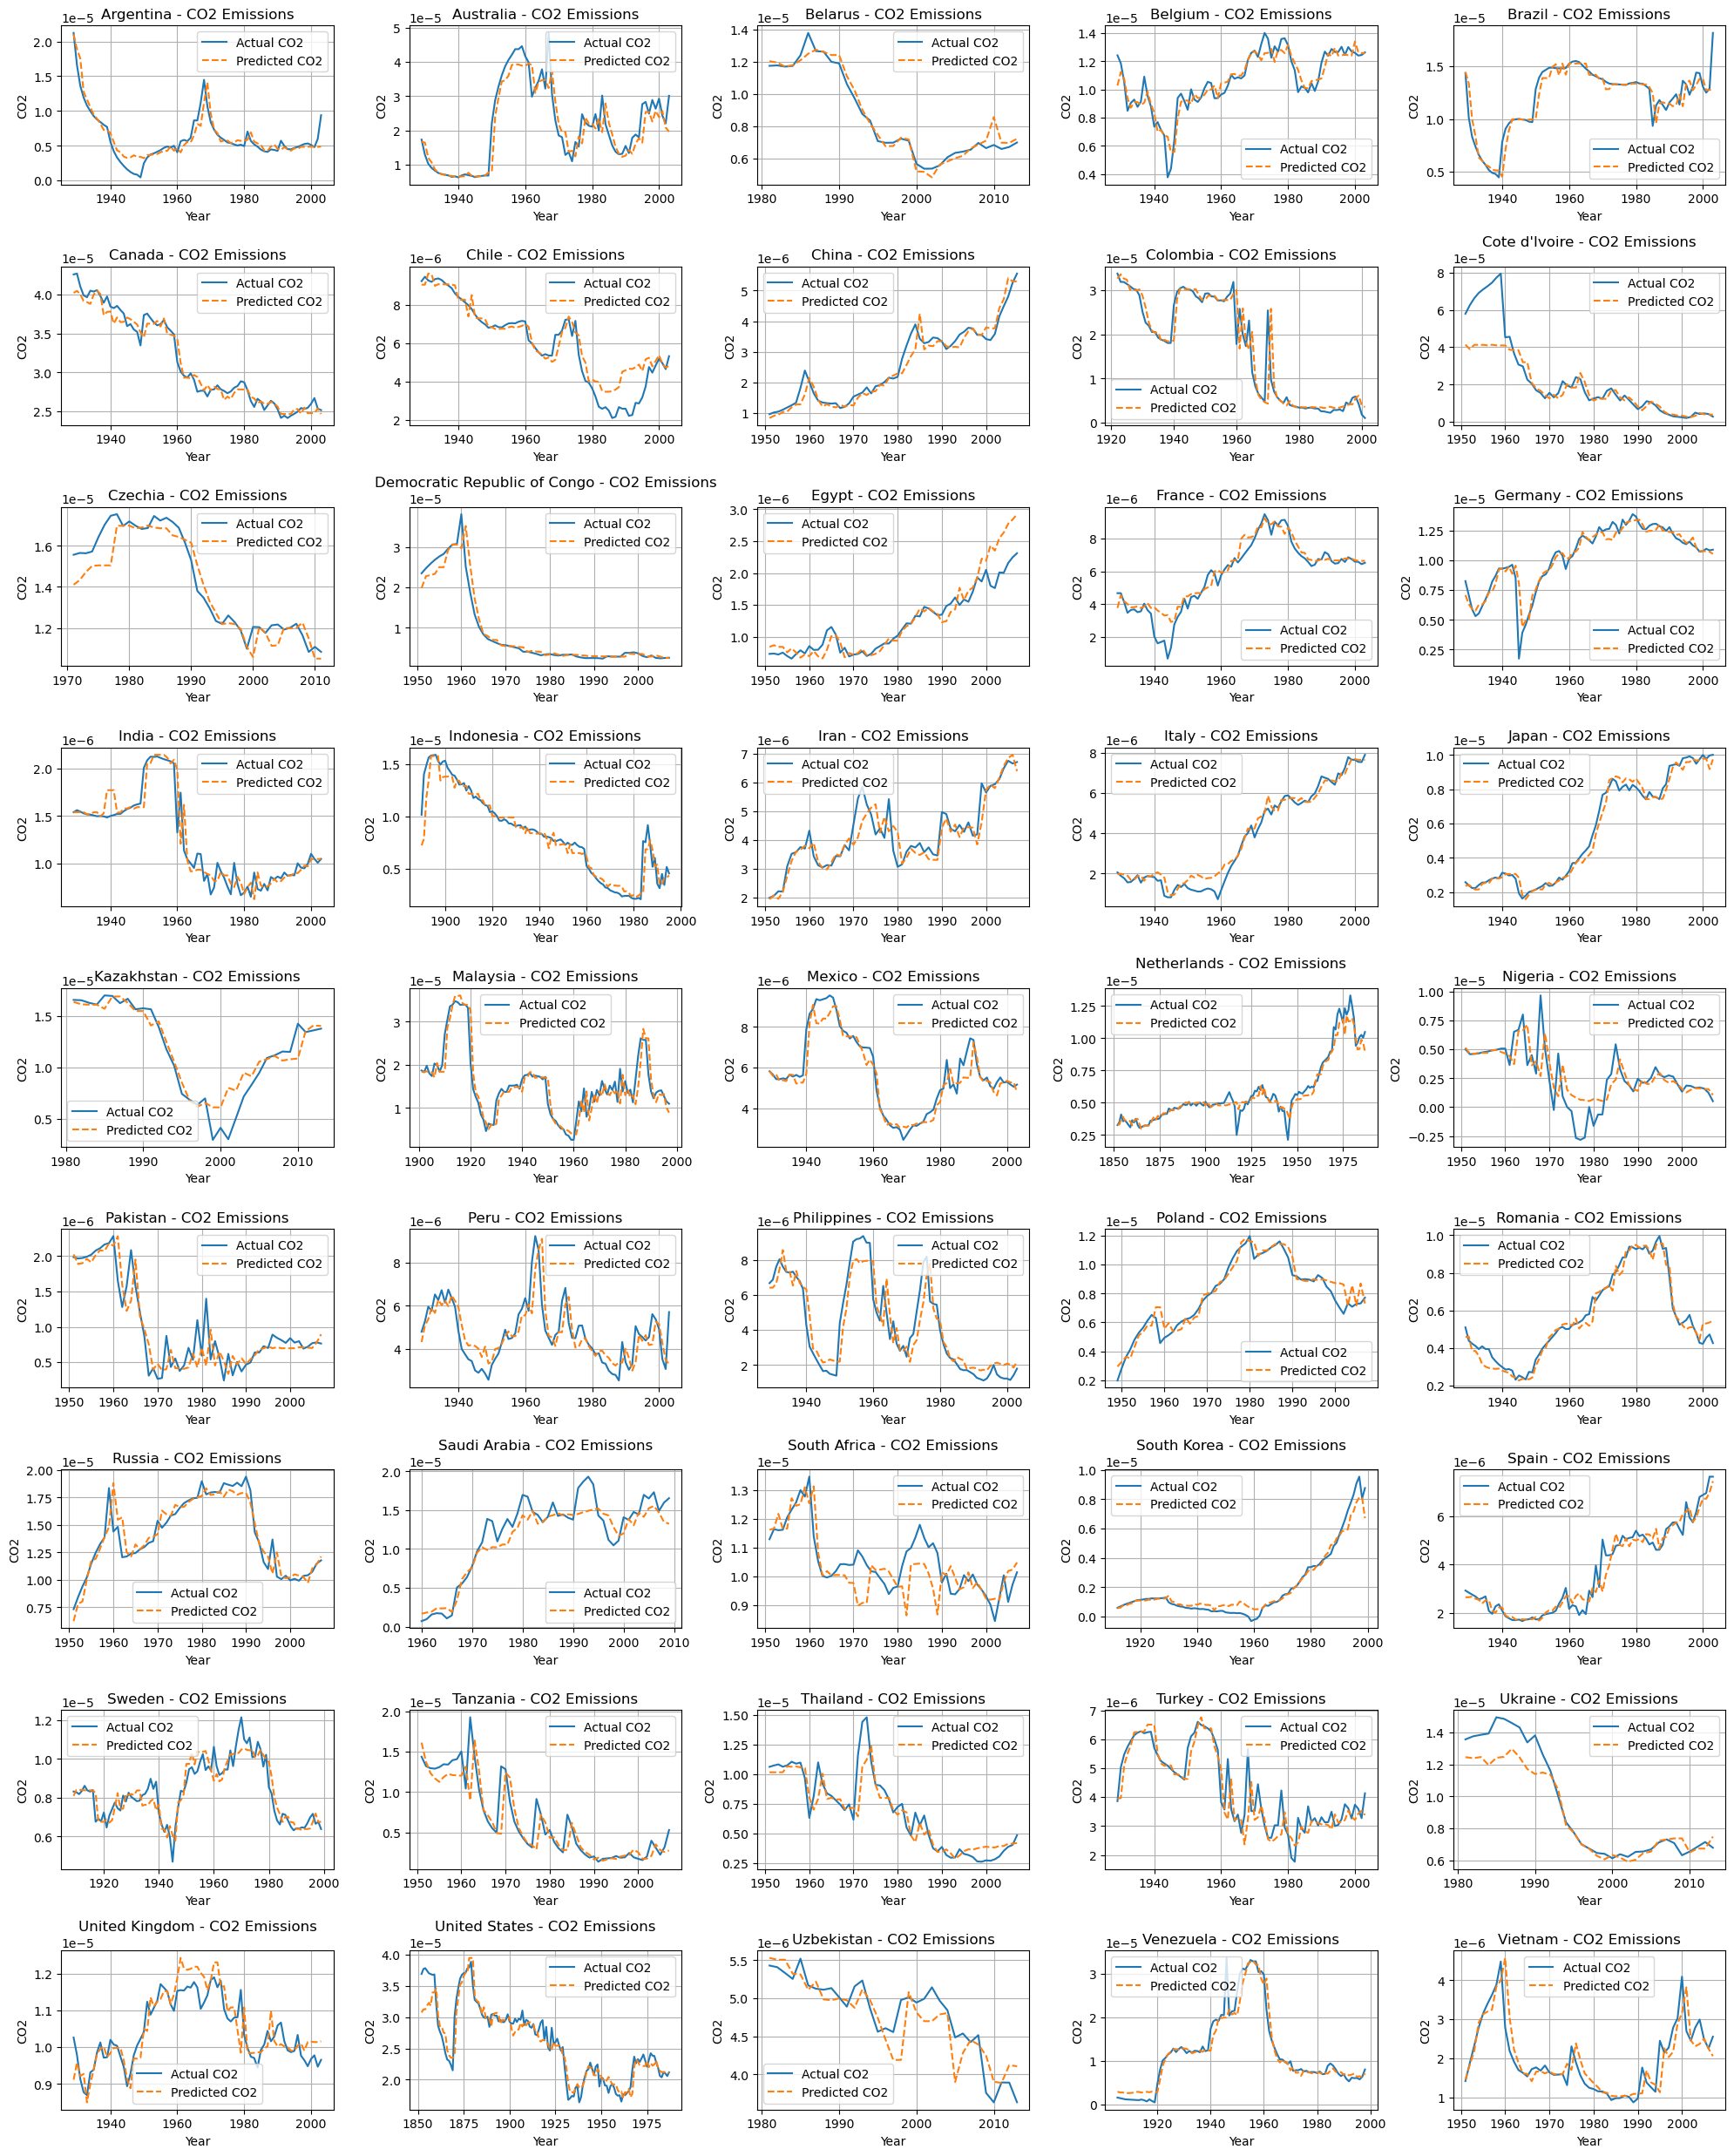

In [28]:
#TRAIN DATA

num_rows = 9
num_cols = 5
countries = results_train_inverse['country'].unique()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_train_inverse[results_train_inverse['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [29]:
all_predictions = []

for country in test_df['country'].unique():

    country_test_data = test_df[test_df['country'] == country].copy()
    horizon = country_test_data['year'].nunique()

    country_test_features = country_test_data.loc[:, country_test_data.columns != 'co2']

    country_predictions = forecast_model.predict(h=horizon, X_df=country_test_features, ids=[country])

    country_predictions['country'] = country
    country_predictions['year'] = country_test_data['year'].values[:len(country_predictions)]
    country_predictions = country_predictions.merge(
        country_test_data[['year', 'co2']],
        on='year',
        how='left'
    ).rename(columns={'co2': 'co2_actual'})

    all_predictions.append(country_predictions)

results_test = pd.concat(all_predictions).reset_index(drop=True).rename(columns={'LGBMRegressor': 'co2_predicted'})

#predicted inverse transform
results_test_inverse = results_test.copy()

output_test_predicted = results_test['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_test_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_test_predicted, results_test.shape[0], test_df.shape[1]-2)
last_column_test_predicted = inverted_data_test_predicted[:, -1]
results_test_inverse['co2_predicted'] = last_column_test_predicted

output_test_actual = results_test['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_test_actual = data_preprocessor_lightgbm.inverse_transform_data(output_test_actual, results_test.shape[0], test_df.shape[1]-2)
last_column_test_actual = inverted_data_test_actual[:, -1]
results_test_inverse['co2_actual'] = last_column_test_actual

results_test_inverse

,country,year,co2_predicted,co2_actual
0,Argentina,2004,0.000008,0.000012
1,Argentina,2005,0.000010,0.000012
2,Argentina,2006,0.000011,0.000013
3,Argentina,2007,0.000011,0.000009
4,Argentina,2008,0.000008,0.000007
...,...,...,...,...
805,Vietnam,2018,0.000004,0.000005
806,Vietnam,2019,0.000005,0.000006
807,Vietnam,2020,0.000006,0.000006
808,Vietnam,2021,0.000007,0.000006


In [30]:
#TRAIN DATA
# Calculate the Mean Absolute Percentage Error (MAPE)
mape_test = mean_absolute_percentage_error(results_test_inverse['co2_actual'], results_test_inverse['co2_predicted'])
print(f"Test MAPE: {mape_test}")

Test MAPE: 0.34554973300935976


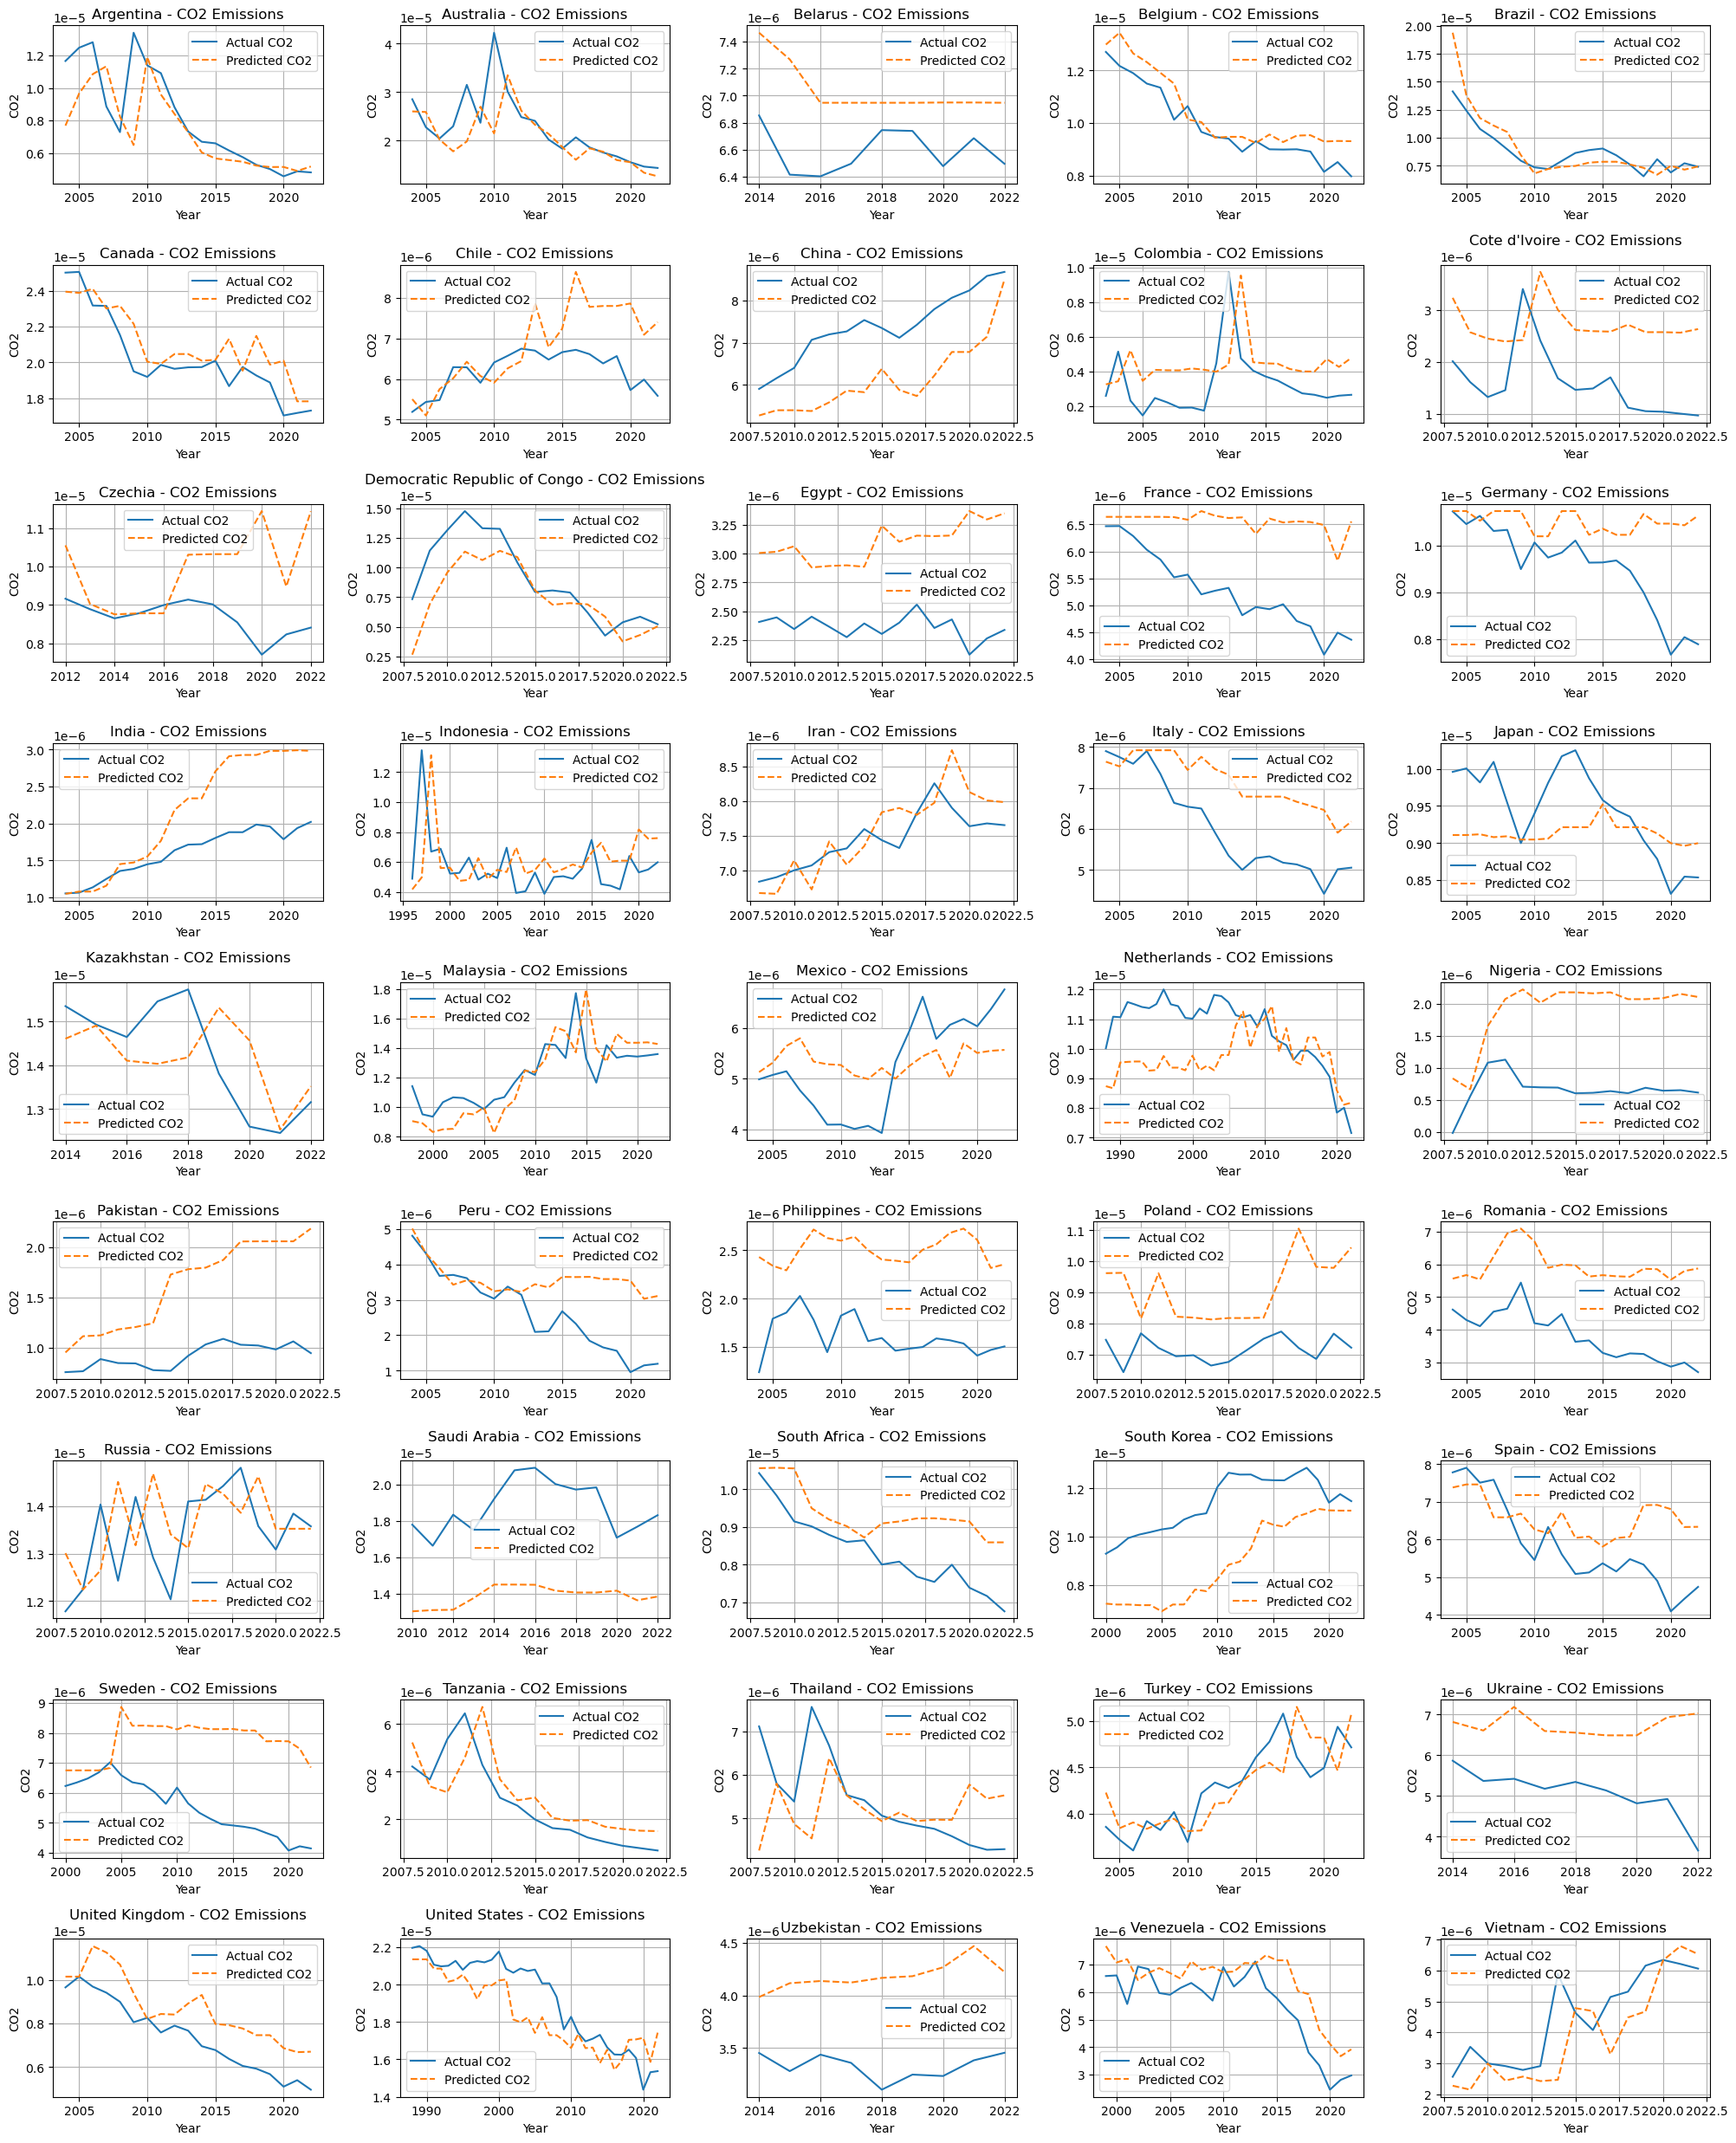

In [31]:
#TEST DATA
num_rows = 9
num_cols = 5
countries = results_test_inverse['country'].unique() 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    country_results = results_test_inverse[results_test_inverse['country'] == country]
    ax = axes[i]
    
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [36]:
# Custom R2 function
def custom_r2_score(y_actual, y_predicted):

    ss_total = np.sum((y_actual - np.mean(y_actual)) ** 2)
    ss_residual = np.sum((y_actual - y_predicted) ** 2)
    r2 = 100 - (ss_residual * 100/ ss_total)
    return max(0, r2)

In [37]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
# TRAIN SET
# Define metrics
metrics = {
    'MAPE': mean_absolute_percentage_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': custom_r2_score
}

# Initialize DataFrame to store results
results_by_country = []

# Calculate metrics for each country
for country in results_train_inverse['country'].unique():
    country_df = results_train_inverse[results_train_inverse['country'] == country]
    actual_values = country_df['co2_actual']
    predicted_values = country_df['co2_predicted']
    country_metrics = {'country': country}
    
    for metric_name, metric_func in metrics.items():
        if len(actual_values) > 1:
            metric_value = metric_func(actual_values, predicted_values)
        else:
            metric_value = np.nan
        country_metrics[metric_name] = metric_value

    results_by_country.append(country_metrics)

# Create a DataFrame for results by country
results_by_country_df = pd.DataFrame(results_by_country)

# Calculate overall metrics
overall_actual = results_train_inverse['co2_actual']
overall_predicted = results_train_inverse['co2_predicted']
overall_metrics = {'country': 'Overall'}

for metric_name, metric_func in metrics.items():
    overall_metrics[metric_name] = metric_func(overall_actual, overall_predicted)

# Append overall metrics to the results DataFrame
overall_metrics_df = pd.DataFrame([overall_metrics])
final_results_df = pd.concat([results_by_country_df, overall_metrics_df], ignore_index=True)

# Display results
print("Metrics by country:")
print(results_by_country_df)
print("\nOverall metrics:")
print(overall_metrics_df)


Metrics by country:
                         country      MAPE           MAE          RMSE  \
0                      Argentina  0.323022  9.167684e-07  1.355791e-06   
1                      Australia  0.131814  3.049406e-06  4.555195e-06   
2                        Belarus  0.041474  3.284725e-07  4.744869e-07   
3                        Belgium  0.060671  5.552494e-07  7.744780e-07   
4                         Brazil  0.058499  6.465703e-07  1.159246e-06   
5                         Canada  0.024958  8.062178e-07  1.054382e-06   
6                          Chile  0.163019  5.579157e-07  8.197881e-07   
7                          China  0.081652  2.058641e-07  2.990168e-07   
8                       Colombia  0.189973  1.806692e-06  3.953575e-06   
9                  Cote d'Ivoire  0.207150  6.416916e-06  1.218756e-05   
10                       Czechia  0.040259  5.853683e-07  8.133123e-07   
11  Democratic Republic of Congo  0.115215  1.123466e-06  2.296038e-06   
12                

In [38]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
# TRAIN SET
# Define metrics
metrics = {
    'MAPE': mean_absolute_percentage_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R2': custom_r2_score
}

# Initialize DataFrame to store results
results_by_country = []

# Calculate metrics for each country
for country in results_test_inverse['country'].unique():
    country_df = results_test_inverse[results_test_inverse['country'] == country]
    actual_values = country_df['co2_actual']
    predicted_values = country_df['co2_predicted']
    country_metrics = {'country': country}
    
    for metric_name, metric_func in metrics.items():
        if len(actual_values) > 1:
            metric_value = metric_func(actual_values, predicted_values)
        else:
            metric_value = np.nan
        country_metrics[metric_name] = metric_value

    results_by_country.append(country_metrics)

# Create a DataFrame for results by country
results_by_country_df = pd.DataFrame(results_by_country)

# Calculate overall metrics
overall_actual = results_test_inverse['co2_actual']
overall_predicted = results_test_inverse['co2_predicted']
overall_metrics = {'country': 'Overall'}

for metric_name, metric_func in metrics.items():
    overall_metrics[metric_name] = metric_func(overall_actual, overall_predicted)

# Append overall metrics to the results DataFrame
overall_metrics_df = pd.DataFrame([overall_metrics])
final_results_df = pd.concat([results_by_country_df, overall_metrics_df], ignore_index=True)

# Display results
print("Metrics by country:")
print(results_by_country_df)
print("\nOverall metrics:")
print(overall_metrics_df)


Metrics by country:
                         country      MAPE           MAE          RMSE  \
0                      Argentina  0.130887  1.313616e-06  2.135569e-06   
1                      Australia  0.117402  3.287575e-06  5.898225e-06   
2                        Belarus  0.068920  4.514798e-07  4.930220e-07   
3                        Belgium  0.065108  6.280607e-07  7.480769e-07   
4                         Brazil  0.103663  1.011009e-06  1.491439e-06   
5                         Canada  0.055804  1.091398e-06  1.415365e-06   
6                          Chile  0.131619  8.147531e-07  1.035209e-06   
7                          China  0.168735  1.243591e-06  1.317616e-06   
8                       Colombia  0.684348  1.907556e-06  2.263411e-06   
9                  Cote d'Ivoire  0.929551  1.254803e-06  1.280609e-06   
10                       Czechia  0.152895  1.284033e-06  1.732014e-06   
11  Democratic Republic of Congo  0.219599  1.940262e-06  2.426276e-06   
12                

In [39]:
results_by_country_df[results_by_country_df['R2'] > 0].reset_index(drop = True)

,country,MAPE,MAE,RMSE,R2
0,Argentina,0.130887,1.313616e-06,2.135569e-06,48.392645
1,Australia,0.117402,3.287575e-06,5.898225e-06,22.333704
2,Belgium,0.065108,6.280607e-07,7.480769e-07,70.577335
3,Brazil,0.103663,1.011009e-06,1.491439e-06,36.917585
4,Canada,0.055804,1.091398e-06,1.415365e-06,62.295267
5,Democratic Republic of Congo,0.219599,1.940262e-06,2.426276e-06,47.872875
6,Iran,0.042737,3.203677e-07,3.736695e-07,6.436805
7,Kazakhstan,0.064077,9.109476e-07,1.133399e-06,9.903930
8,Malaysia,0.114888,1.419930e-06,1.781458e-06,14.188679
9,Mexico,0.158780,7.844357e-07,8.676408e-07,14.139065
